# Affordance Heatmaps

This notebook visualizes the pick and place affordance predictions of a pre-trained `multi-language-conditioned` agent from the quickstart guide.

### Setup

- Set the root folder environment variable with `export CLIPORT_ROOT=<cliport_root>`
- Complete the [quickstart guide](https://github.com/cliport/cliport#quickstart) in README.md
- Generate `val` and `test` splits for the task you want to evaluate on by running `python cliport/demos.py n=10 mode=test task=stack-block-pyramid-seq-seen-colors`

In [11]:
            # set GPU
# %env CUDA_VISIBLE_DEVICES=0

import os
import sys
import json


import numpy as np
from cliport import tasks
from cliport import agents
from cliport.utils import utils

import torch
torch.set_default_device("cpu")
import cv2
from cliport.dataset import RavensDataset
from cliport.environments.environment import Environment

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

### Settings

In [12]:
train_demos = 100 # number training demonstrations used to train agent
n_eval = 0 # number of evaluation instances
mode = 'test' # val or test

agent_name = 'cliport'
model_task = 'build-car' # multi-task agent conditioned with language goals

model_folder = 'cliport/exps' # path to pre-trained checkpoint
ckpt_name = 'last.ckpt' # name of checkpoint to load

draw_grasp_lines = True
affordance_heatmap_scale = 30

### Uncomment the task you want to evaluate on ###
eval_task = 'build-car'

# eval_task = 'align-rope'
# eval_task = 'assembling-kits-seq-seen-colors'
# eval_task = 'assembling-kits-seq-unseen-colors'
# eval_task = 'packing-shapes'
# eval_task = 'packing-boxes-pairs-seen-colors'
# eval_task = 'packing-boxes-pairs-unseen-colors'
# eval_task = 'packing-seen-google-objects-seq'
# eval_task = 'packing-unseen-google-objects-seq'
# eval_task = 'packing-seen-google-objects-group'
# eval_task = 'packing-unseen-google-objects-group'
# eval_task = 'put-block-in-bowl-seen-colors'
# eval_task = 'put-block-in-bowl-unseen-colors'
# eval_task = 'stack-block-pyramid-seq-seen-colors'
# eval_task = 'stack-block-pyramid-seq-unseen-colors'
# eval_task = 'separating-piles-seen-colors'
# eval_task = 'separating-piles-unseen-colors'
# eval_task = 'towers-of-hanoi-seq-seen-colors'
# eval_task = 'towers-of-hanoi-seq-unseen-colors'

### Load Configs and Agent

In [13]:
import os

os.environ['GENSIM_ROOT'] = os.getcwd() 
os.environ['CLIPORT_ROOT'] = os.getcwd() 


In [14]:
os.getcwd()

'/home/cosmos/VScode Projects/coglab/GenSim'

In [21]:
root_dir = os.environ['GENSIM_ROOT']
assets_root = os.path.join(root_dir, 'cliport/environments/assets/')
config_file = 'my_eval.yaml' 

from hydra import compose, initialize
from omegaconf import OmegaConf
from torch.utils.data import DataLoader


with initialize(version_base='1.2', config_path='cliport/cfg'):
    vcfg = compose(config_name=config_file)

# vcfg = utils.load_hydra_config(os.path.join(root_dir, f'cfg/{config_file}'))
vcfg['data_dir'] = os.path.join(root_dir, 'data')
vcfg['mode'] = mode

vcfg['model_task'] = model_task
vcfg['eval_task'] = eval_task
vcfg['agent'] = agent_name

# Model and training config paths
model_path = os.path.join(root_dir, model_folder)
vcfg['train_config'] = "/home/cosmos/VScode Projects/coglab/GenSim/cliport/cfg/train.yaml" #f"{model_path}/{vcfg['model_task']}-{vcfg['agent']}-n{train_demos}-train/.hydra/config.yaml"
vcfg['model_path'] = "/home/cosmos/VScode Projects/coglab/GenSim/data/GenSim_Data_Train/checkpoints/checkpoints" #f"{model_path}/{vcfg['model_task']}-{vcfg['agent']}-n{train_demos}-train/checkpoints/"
vcfg['record']['save_video_path'] = f"{root_dir}/videos/{eval_task}/"


tcfg = utils.load_hydra_config(vcfg['train_config'])

# Load dataset
ds = RavensDataset(os.path.join(vcfg['data_dir'], f'{vcfg["eval_task"]}-{vcfg["mode"]}'), 
                   tcfg, 
                   n_demos=n_eval,
                   augment=False)

data_loader = DataLoader(ds, shuffle=False,
                    pin_memory=False,
                    num_workers=0)

eval_run = 0
seed = 0
name = '{}-{}-{}-{}'.format(vcfg['eval_task'], vcfg['agent'], n_eval, eval_run)
print(f'\nEval ID: {name}\n')

# Initialize agent
utils.set_seed(seed, torch=True)

agent = agents.names[vcfg['agent']](name, tcfg, data_loader, data_loader)

# Load checkpoint
ckpt_path = os.path.join(vcfg['model_path'], ckpt_name)
print(f'\nLoading checkpoint: {ckpt_path}')
agent.load(ckpt_path)


Eval ID: build-car-cliport-0-0

Attn FCN - Stream One: plain_resnet_lat, Stream Two: clip_lingunet_lat, Stream Fusion: add
Transport FCN - Stream One: plain_resnet_lat, Stream Two: clip_lingunet_lat, Stream Fusion: conv
Agent: build-car-cliport-0-0, Logging: True

Loading checkpoint: /home/cosmos/VScode Projects/coglab/GenSim/data/GenSim_Data_Train/checkpoints/checkpoints/last.ckpt


In [22]:
device = torch.device('cpu')

In [23]:
agent = agent.to(dtype=torch.float).to(device) 

### Spawn Environment

In [24]:
# Initialize environment and task.
env = Environment(
    assets_root,
    disp=False,
    shared_memory=False,
    hz=480,
    record_cfg=vcfg['record']
)

text argument:/home/cosmos/VScode Projects/coglab/GenSim/cliport/environments/assets/
int args: [

In [25]:
print(vcfg['record'])

{'save_video': True, 'save_video_path': '/home/cosmos/VScode Projects/coglab/GenSim/videos/build-car/', 'add_text': False, 'fps': 20, 'video_height': 640, 'video_width': 720, 'add_task_text': True}


### Evaluate Agent


Evaluation Instance: 1/1
Step: 0 (15 max)
torch.Size([1, 36, 320, 160])
Lang Goal: Firstly, create the base of the car by positioning two red blocks side by side.


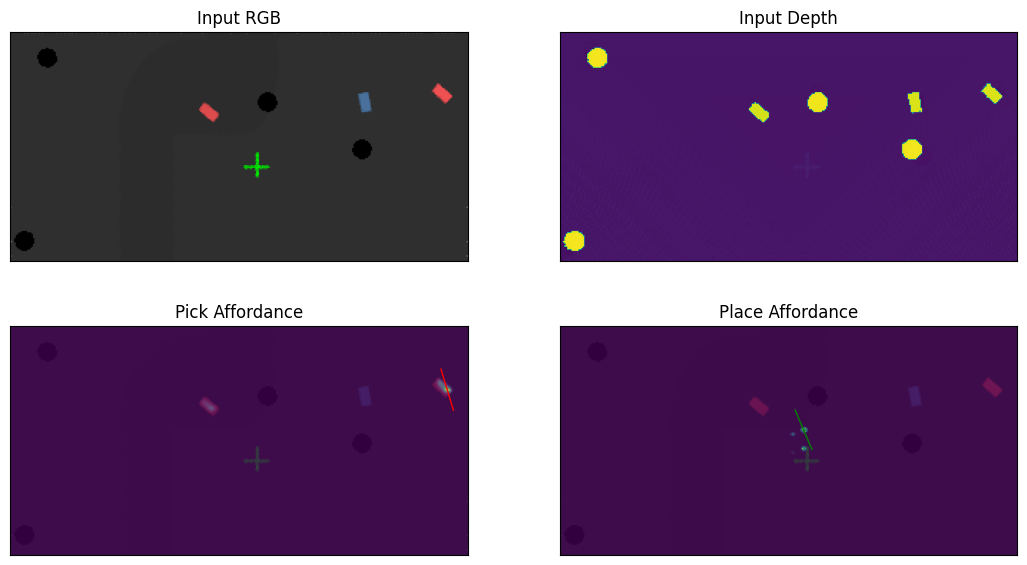

[libx264 @ 0x62368c0] -qscale is ignored, -crf is recommended.


object 1 match with target 1 rew: 0.167
Step Reward: 0.16666666666666666
Total Reward: 0.16666666666666666
Step: 1 (15 max)
torch.Size([1, 36, 320, 160])
Lang Goal: Firstly, create the base of the car by positioning two red blocks side by side.


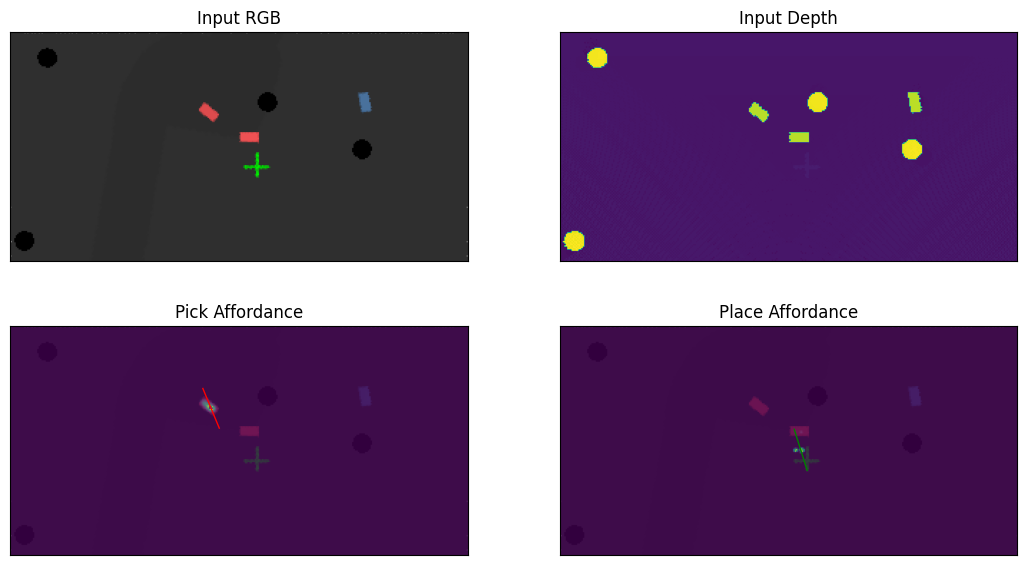

object 0 match with target 0 rew: 0.167
object 1 match with target 1 rew: 0.333
Step Reward: 0.16666666666666666
Total Reward: 0.3333333333333333
Step: 2 (15 max)
torch.Size([1, 36, 320, 160])
Lang Goal: Then, add the car body by stacking a blue block on top of the base.


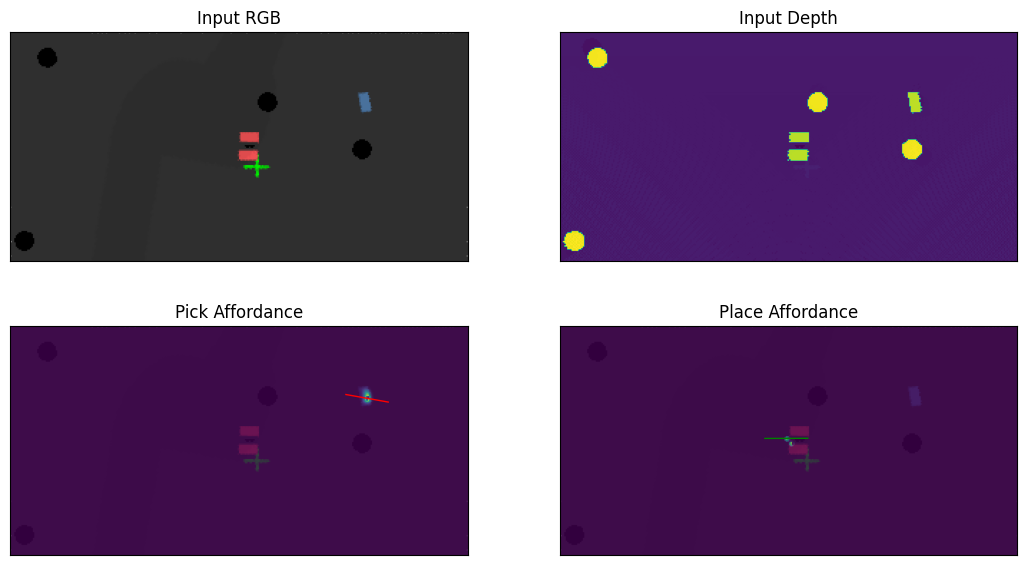

Step Reward: 0.0
Total Reward: 0.3333333333333333
Step: 3 (15 max)
torch.Size([1, 36, 320, 160])
Lang Goal: Then, add the car body by stacking a blue block on top of the base.


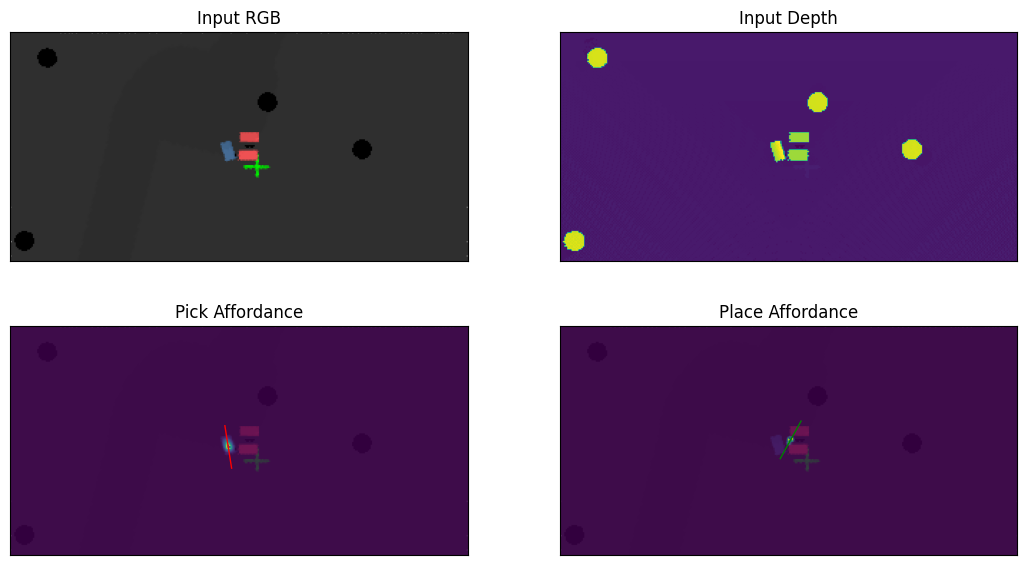

Step Reward: 0.0
Total Reward: 0.3333333333333333
Step: 4 (15 max)
torch.Size([1, 36, 320, 160])
Lang Goal: Then, add the car body by stacking a blue block on top of the base.


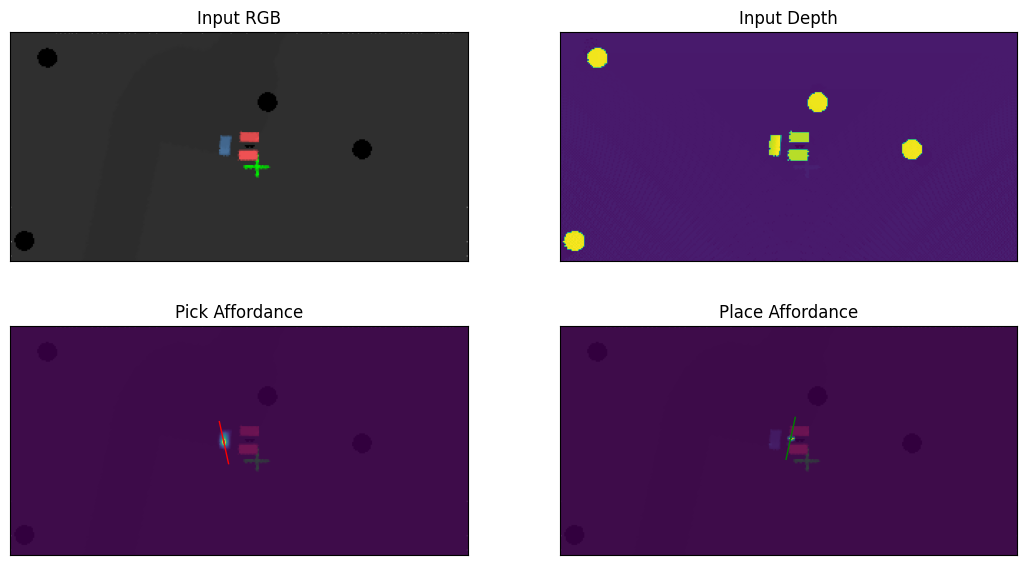

Step Reward: 0.0
Total Reward: 0.3333333333333333
Step: 5 (15 max)
torch.Size([1, 36, 320, 160])
Lang Goal: Then, add the car body by stacking a blue block on top of the base.


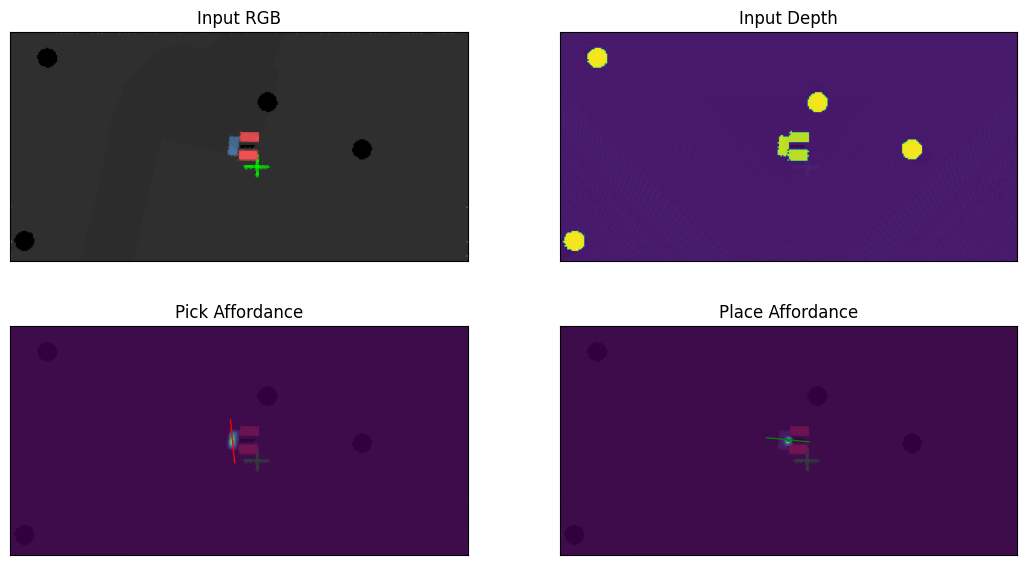

object 0 match with target 0 rew: 0.333
Step Reward: 0.3333333333333333
Total Reward: 0.6666666666666666
Step: 6 (15 max)
torch.Size([1, 36, 320, 160])
Lang Goal: For the wheels, place a black cylinder on each side of the base blocks.


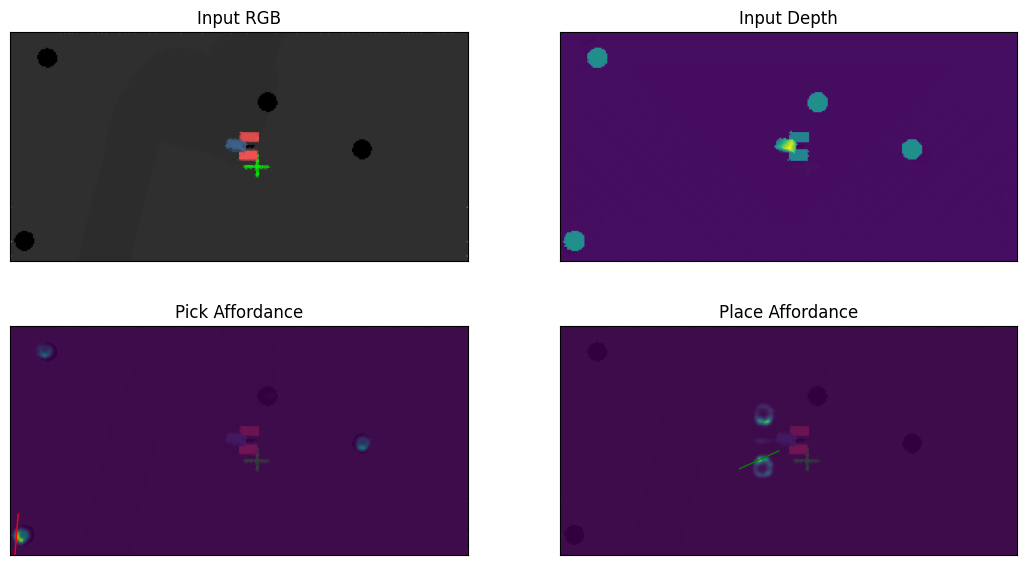

object 2 match with target 2 rew: 0.083
Step Reward: 0.08333333333333337
Total Reward: 0.75
Step: 7 (15 max)
torch.Size([1, 36, 320, 160])
Lang Goal: For the wheels, place a black cylinder on each side of the base blocks.


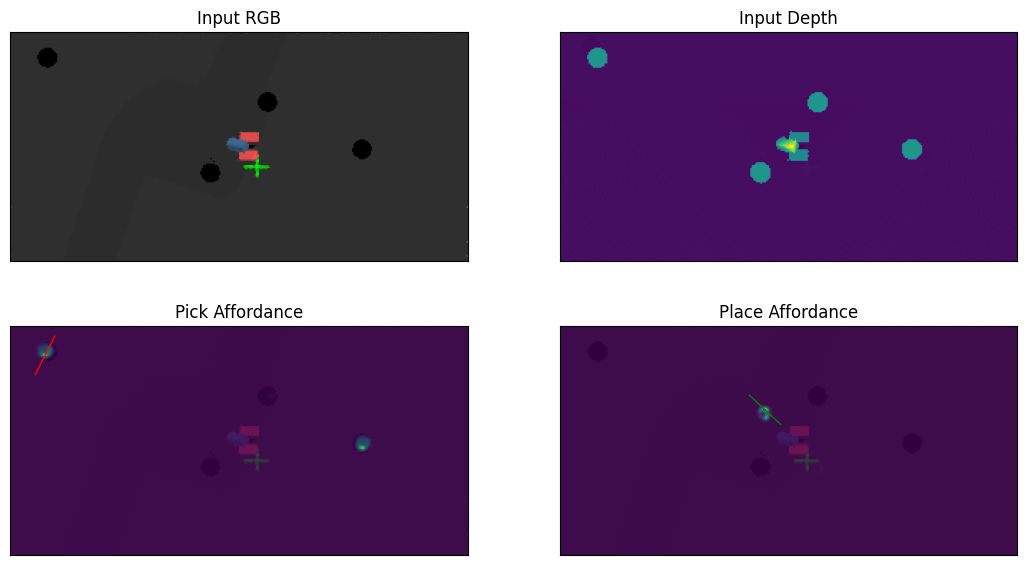

object 1 match with target 3 rew: 0.083
object 2 match with target 2 rew: 0.167
Step Reward: 0.08333333333333326
Total Reward: 0.8333333333333333
Step: 8 (15 max)
torch.Size([1, 36, 320, 160])
Lang Goal: For the wheels, place a black cylinder on each side of the base blocks.


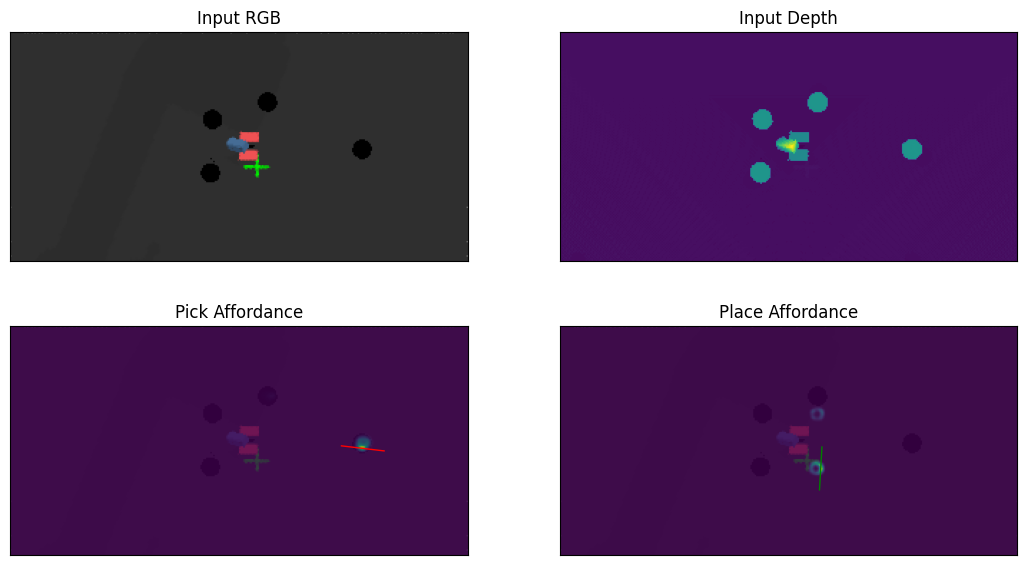

object 1 match with target 3 rew: 0.083
object 2 match with target 2 rew: 0.167
object 3 match with target 0 rew: 0.250
Step Reward: 0.08333333333333337
Total Reward: 0.9166666666666666
Step: 9 (15 max)
torch.Size([1, 36, 320, 160])
Lang Goal: For the wheels, place a black cylinder on each side of the base blocks.


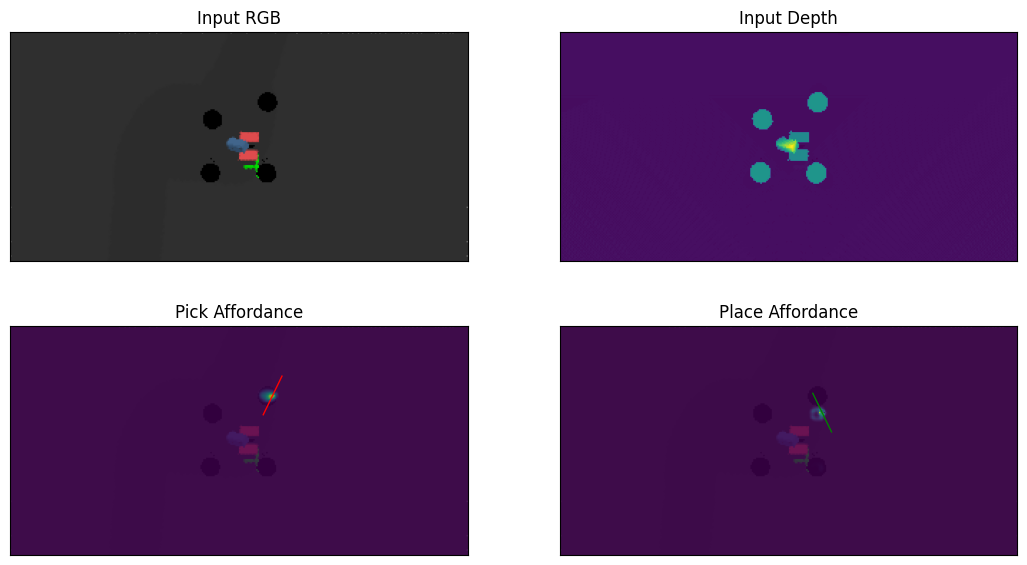

object 0 match with target 1 rew: 0.083
object 1 match with target 3 rew: 0.167
object 2 match with target 2 rew: 0.250
object 3 match with target 0 rew: 0.333
Step Reward: 0.08333333333333337
Total Reward: 1.0
Done. Success.


In [26]:
episode = 0
num_eval_instances = 1

episode_history = []
total_reward = 0

if vcfg['record']['save_video']:
    env.start_rec(f'{eval_run}_{ds.n_episodes+1:06d}')

for i in range(num_eval_instances):
    print(f'\nEvaluation Instance: {i + 1}/{num_eval_instances}')
    
    # Load episode
    # episode, _ = ds.load(i)
    # goal = episode[-1]
    total_reward = 0

    # Set task
    task_name = vcfg['eval_task']
    task = tasks.names[task_name]()
    task.mode = mode
    
    # Set environment
    env.seed(seed)
    env.set_task(task)
    obs = env.reset()
    info = env.info
    reward = 0
    total_reward = 0
    
    step = 0
    done = False


    with open(f"{root_dir}/runs/seed_{eval_run}.txt", "w+") as txt_file:
        txt_file.write("")

    # Rollout
    while (step <= task.max_steps) and not done:
        print(f"Step: {step} ({task.max_steps} max)")
        
        # Get batch
        if step == task.max_steps-1:
            batch = ds.process_goal((obs, None, reward, info), perturb_params=None)
        else:
            batch = ds.process_sample((obs, None, reward, info), augment=False)

        fig, axs = plt.subplots(2, 2, figsize=(13, 7))
        
        # Get color and depth inputs
        img = batch['img']
        img = torch.from_numpy(img)
        color = np.uint8(img.detach().cpu().numpy())[:,:,:3]
        color = color.transpose(1,0,2)
        depth = np.array(img.detach().cpu().numpy())[:,:,3]
        depth = depth.transpose(1,0)
        
        # Display input color
        axs[0,0].imshow(color)
        axs[0,0].axes.xaxis.set_visible(False)
        axs[0,0].axes.yaxis.set_visible(False)
        axs[0,0].set_title('Input RGB')
        
        # Display input depth
        axs[0,1].imshow(depth)
        axs[0,1].axes.xaxis.set_visible(False)
        axs[0,1].axes.yaxis.set_visible(False)        
        axs[0,1].set_title('Input Depth')
        
        # Display predicted pick affordance
        axs[1,0].imshow(color)
        axs[1,0].axes.xaxis.set_visible(False)
        axs[1,0].axes.yaxis.set_visible(False)
        axs[1,0].set_title('Pick Affordance')
        
        # Display predicted place affordance
        axs[1,1].imshow(color)
        axs[1,1].axes.xaxis.set_visible(False)
        axs[1,1].axes.yaxis.set_visible(False)
        axs[1,1].set_title('Place Affordance')
        
        # Get action predictions
        l = str(info['lang_goal'])
        act = agent.act(obs, info, goal=None)
        pick, place = act['pick'], act['place']
        
        # Visualize pick affordance
        pick_inp = {'inp_img': batch['img'], 'lang_goal': l}
        pick_conf = agent.attn_forward(pick_inp)
        logits = pick_conf.detach().cpu().numpy()[0].transpose(1, 2, 0)

        pick_conf = pick_conf.detach().cpu().numpy()
        argmax = np.argmax(pick_conf)
        argmax = np.unravel_index(argmax, shape=pick_conf.shape)
        p0 = argmax[:2]
        p0_theta = (argmax[2] * (2 * np.pi / pick_conf.shape[2])) * -1.0
    
        line_len = 30
        pick0 = (pick[0] + line_len/2.0 * np.sin(p0_theta), pick[1] + line_len/2.0 * np.cos(p0_theta))
        pick1 = (pick[0] - line_len/2.0 * np.sin(p0_theta), pick[1] - line_len/2.0 * np.cos(p0_theta))

        if draw_grasp_lines:
            axs[1,0].plot((pick1[0], pick0[0]), (pick1[1], pick0[1]), color='r', linewidth=1)
        
        # Visualize place affordance
        place_inp = {'inp_img': batch['img'], 'p0': pick, 'lang_goal': l}
        place_conf = agent.trans_forward(place_inp)

        print(place_conf.shape)

        place_conf = place_conf[0].permute(1, 2, 0)
        place_conf = place_conf.detach().cpu().numpy()
        argmax = np.argmax(place_conf)
        argmax = np.unravel_index(argmax, shape=place_conf.shape)
        p1_pix = argmax[:2]
        p1_theta = (argmax[2] * (2 * np.pi / place_conf.shape[2]) + p0_theta) * -1.0
        
        line_len = 30
        place0 = (place[0] + line_len/2.0 * np.sin(p1_theta), place[1] + line_len/2.0 * np.cos(p1_theta))
        place1 = (place[0] - line_len/2.0 * np.sin(p1_theta), place[1] - line_len/2.0 * np.cos(p1_theta))

        if draw_grasp_lines:
            axs[1,1].plot((place1[0], place0[0]), (place1[1], place0[1]), color='g', linewidth=1)
        
        # Overlay affordances on RGB input
        pick_logits_disp = np.uint8(logits * 255 * affordance_heatmap_scale).transpose(1,0,2)
        place_logits_disp = np.uint8(np.sum(place_conf, axis=2)[:,:,None] * 255 * affordance_heatmap_scale).transpose(1,0,2)    

        pick_logits_disp_masked = np.ma.masked_where(pick_logits_disp < 0, pick_logits_disp)
        place_logits_disp_masked = np.ma.masked_where(place_logits_disp < 0, place_logits_disp)

        axs[1][0].imshow(pick_logits_disp_masked, alpha=0.75)
        axs[1][1].imshow(place_logits_disp_masked, cmap='viridis', alpha=0.75)
        
        print(f"Lang Goal: {str(info['lang_goal'])}")
        plt.show()
        
        # Act with the predicted actions
        obs, reward, done, info = env.step(act)

        print(f"Step Reward: {reward}")
        total_reward += reward
        print(f"Total Reward: {total_reward}")
        step += 1

        episode_history.append((obs, act, reward, info))


        with open(f"{root_dir}/runs/seed_{seed}.txt", "a") as txt_file:
            txt_file.write(" ".join(str(episode_history[-1])) + "\n")
        
    if done:
        with open(f"{root_dir}/runs/seed_{seed}.txt", "a") as txt_file:
            txt_file.write("Done. Success." + "\n")
        print("Done. Success.")
    else:
        with open(f"{root_dir}/runs/seed_{seed}.txt", "a") as txt_file:
            txt_file.write("Max steps reached. Task failed." + "\n")
        print("Max steps reached. Task failed.")
# Only save completed demonstrations.
if vcfg['save_results'] and total_reward > 0.99:
    ds.add(seed, episode_history)

if vcfg['record']['save_video']:
    env.end_rec()